In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import ks_2samp

In [6]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
consDF_all = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')

consDF = consDF_all.dropna()
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')

cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')


In [7]:
display(acctDF), display(consDF), display(trxnDF)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.7500
24462,11615,24462,SAVINGS,2022-03-30,5.0000
24463,11615,24463,CHECKING,2022-03-30,"1,956.4600"
24464,12210,24464,CHECKING,2022-03-28,"2,701.5100"


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000
...,...,...,...,...
13995,13995,2022-01-22,802.0000,0.0000
13996,13996,2022-02-01,652.0000,0.0000
13997,13997,2021-12-24,765.0000,0.0000
13998,13998,2022-01-30,685.0000,0.0000


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.9600,DEBIT,2022-03-11
6407317,10533,6405305,12,63.4800,DEBIT,2022-03-30
6407318,10533,6405306,12,53.9900,DEBIT,2022-03-30
6407319,10533,6405307,12,175.9800,DEBIT,2022-03-31


(None, None, None)

In [13]:
acctConsDF = consDF.merge(acctDF, how='left', on='prism_consumer_id',)
acctConsDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,0,2021-09-01,726.0000,0.0000,862,SAVINGS,2021-08-31,25.7000
1,0,2021-09-01,726.0000,0.0000,863,CHECKING,2021-08-31,294.6700
2,1,2021-07-01,626.0000,0.0000,7754,SAVINGS,2021-06-30,"3,211.1800"
3,1,2021-07-01,626.0000,0.0000,7755,CHECKING,2021-06-30,91.2400
4,2,2021-05-01,680.0000,0.0000,4666,SAVINGS,2021-04-30,"2,561.4300"


# Week 1 - Best Single Feature

### Test Predictability w/ Logistic Regression Model

In [63]:
def lr_best_single(X, y):
    """
    Trains a logistic regression model on the provided data, evaluates its performance, 
    and returns key metrics.

    Parameters:
    ----------
    X : array-like or DataFrame
        Feature matrix containing predictor variables.
    y : array-like or Series
        Target variable (binary classification).

    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute R^2
    # ll_model = -log_loss(y, model.predict_proba(X), normalize=False)
    # ll_null = -log_loss(y, [y.mean()] * len(y), normalize=False)
    # r2 = 1 - (ll_model / ll_null)

    r = np.corrcoef(y.squeeze(), X.squeeze())[0][1]
    r2 = (r) ** 2
    

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"r^2 value: {r2:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, roc_auc, confusion_matrix, classification_report(y_test, y_pred)


In [64]:
def ks_test(data, ftr='credit_score', target='DQ_TARGET'):
    """
    Performs the Kolmogorov-Smirnov (KS) test to compare the distributions 
    of two samples and returns the KS statistic and p-value.

    Parameters:
    ----------
    ftr_0 : array-like
        Sample values for the first group (e.g., feature values for class 0).
    ftr_1 : array-like
        Sample values for the second group (e.g., feature values for class 1).

    Returns:
    -------
    ks_stat : float
        The KS statistic, representing the maximum difference between the two cumulative distributions.
    p_value : float
        The p-value indicating the significance of the difference between the distributions.


    Notes:
    ------

    If the P value is small, conclude that the two groups were sampled from populations with different distributions. 
    The populations may differ in median, variability or the shape of the distribution.

    """
    
    ftr_0 = data[data[target] == 0][ftr]
    ftr_1 = data[data[target] == 1][ftr]
    ks_stat, p_value = ks_2samp(ftr_0, ftr_1)

    print(f"KS_stat  = {ks_stat}")
    print(f"p value = {p_value}")

    plt.figure(figsize=(8, 6))
    plt.hist(ftr_0, bins=30, alpha=0.5, label=ftr+"_0", density=True)
    plt.hist(ftr_1, bins=30, alpha=0.5, label=ftr+"_1", density=True)
    plt.title("Feature Distribution by Class")
    plt.xlabel("Feature Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    
    return ks_stat, p_value


In [9]:
y = consDF[['DQ_TARGET']]

### Credit Score - DQ_TARGET

In [65]:
credit_scoreDF = consDF[['credit_score', 'DQ_TARGET']]
credit_scoreDF.head()

,credit_score,DQ_TARGET
0,726.0000,0.0000
1,626.0000,0.0000
2,680.0000,0.0000
3,734.0000,0.0000
4,676.0000,0.0000


In [66]:
corr_credit_score = consDF['credit_score'].corr(consDF.DQ_TARGET)
corr_credit_score

-0.2613083627746771

In [67]:
np.corrcoef(cs_X.credit_score, y.DQ_TARGET)[0][1]

-0.2613083627746771

In [68]:
cs_X = consDF[['credit_score']]

lr_best_single(cs_X, y)

ROC AUC Score: 0.7497
Accuracy: 0.9125
r^2 value: 0.0683

Confusion Matrix:
[[2187    5]
 [ 205    3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.38      0.01      0.03       208

    accuracy                           0.91      2400
   macro avg       0.64      0.51      0.49      2400
weighted avg       0.87      0.91      0.87      2400



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9125,
 0.7496808762633352,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>,
 '              precision    recall  f1-score   support\n\n         0.0       0.91      1.00      0.95      2192\n         1.0       0.38      0.01      0.03       208\n\n    accuracy                           0.91      2400\n   macro avg       0.64      0.51      0.49      2400\nweighted avg       0.87      0.91      0.87      2400\n')

KS_stat  = 0.3881249523054506
p value = 1.4927461734165962e-125


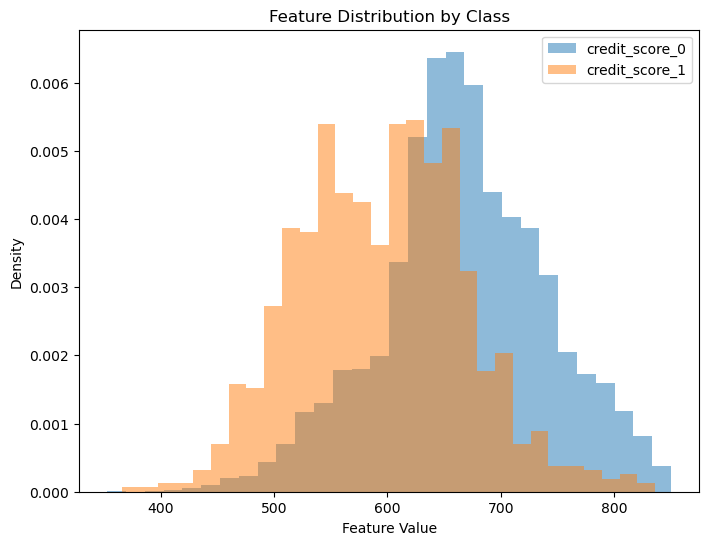

(0.3881249523054506, 1.4927461734165962e-125)

In [69]:
ks_test(consDF, ftr='credit_score', target='DQ_TARGET')

### Credit / Debit - DQ Target

In [70]:
consTrxnDF = consDF.merge(trxnDF, how='left', on='prism_consumer_id',)
consTrxnDF['cd_num'] = consTrxnDF.credit_or_debit.apply(lambda x: 1 if x == 'CREDIT' else 0)
consTrxnDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_transaction_id,category,amount,credit_or_debit,posted_date,cd_num
0,0,2021-09-01,726.0000,0.0000,136696,4.0000,0.0900,CREDIT,2021-03-19,1
1,0,2021-09-01,726.0000,0.0000,136697,4.0000,0.0500,CREDIT,2021-04-16,1
2,0,2021-09-01,726.0000,0.0000,136698,4.0000,0.0600,CREDIT,2021-05-21,1
3,0,2021-09-01,726.0000,0.0000,136699,4.0000,0.0400,CREDIT,2021-06-18,1
4,0,2021-09-01,726.0000,0.0000,136700,4.0000,0.0200,CREDIT,2021-07-16,1


In [71]:
cd_dq = consTrxnDF[['cd_num', 'DQ_TARGET']]
cd_dq.head()

,cd_num,DQ_TARGET
0,1,0.0000
1,1,0.0000
2,1,0.0000
3,1,0.0000
4,1,0.0000


In [29]:
corr_cd = consTrxnDF.cd_num.corr(consTrxnDF.DQ_TARGET)
corr_cd

0.010555130377445368

In [72]:
cd_X = consTrxnDF[['cd_num']]
y = consTrxnDF[['DQ_TARGET']]
lr_best_single(cd_X, y)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC AUC Score: 0.5077
Accuracy: 0.9249
r^2 value: 0.0001

Confusion Matrix:
[[950280      0]
 [ 77167      0]]

Classification Report:


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    950280
         1.0       0.00      0.00      0.00     77167

    accuracy                           0.92   1027447
   macro avg       0.46      0.50      0.48   1027447
weighted avg       0.86      0.92      0.89   1027447



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.9248944227780119,
 0.5076684566964006,
 <function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>,
 '              precision    recall  f1-score   support\n\n         0.0       0.92      1.00      0.96    950280\n         1.0       0.00      0.00      0.00     77167\n\n    accuracy                           0.92   1027447\n   macro avg       0.46      0.50      0.48   1027447\nweighted avg       0.86      0.92      0.89   1027447\n')